In [1]:
from train_functions import train_sahp
import torch
import pickle
import numpy as np

from utils.load_synth_data import process_loaded_sequences
from utils.util import get_batch,count_parameters
from utils.atten_optimizer import NoamOpt
from train_functions.train_sahp import make_model,eval_sahp,prediction_evaluation,MaskBatch
import seaborn as sns
import matplotlib.pyplot as plt
from utils import evaluation


import torch.optim as optim
import random
import math

def get_pairwise_times(event_time):
    xt_bar = event_time.unsqueeze(1). \
        expand(event_time.size(0), event_time.size(1), event_time.size(1))
    xt = xt_bar.transpose(1, 2)
    return (xt_bar, xt)


def get_pairwise_type_embeddings(embeddings):
    xd_bar = embeddings.unsqueeze(1).expand(embeddings.size(
        0), embeddings.size(1), embeddings.size(1), embeddings.size(-1))
    xd = xd_bar.transpose(1, 2)

    return (xd_bar, xd)


## Synth Model

In [253]:
model = train_sahp.make_model(max_sequence_length=324)
model_dict =torch.load('saved_models/sahp-synthetic_hidden16-20210622-205430',map_location=torch.device('cpu'))
model.load_state_dict(model_dict)

with open('data/simulated/hawkes_synthetic_random_2d_20191130-180837.pkl', 'rb') as f:
    loaded_hawkes_data = pickle.load(f)


seq_times, seq_types, seq_lengths, _ = process_loaded_sequences(loaded_hawkes_data, 2)

total_sample_size = seq_times.size(0)
train_ratio = 0.8
train_size = int(train_ratio * total_sample_size)
dev_ratio =0.1
dev_size = int(dev_ratio * total_sample_size)
## Split Traning and Test Sets
train_seq_times = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]


dev_seq_times = seq_times[train_size:train_size + dev_size]  # train_size+dev_size
dev_seq_types = seq_types[train_size:train_size + dev_size]
dev_seq_lengths = seq_lengths[train_size:train_size + dev_size]

test_seq_times = seq_times[-dev_size:]
test_seq_types = seq_types[-dev_size:]
test_seq_lengths = seq_lengths[-dev_size:]


## sequence length
train_seq_lengths, reorder_indices_train = train_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
train_seq_times = train_seq_times[reorder_indices_train]
train_seq_types = train_seq_types[reorder_indices_train]
#
dev_seq_lengths, reorder_indices_dev = dev_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
dev_seq_times = dev_seq_times[reorder_indices_dev]
dev_seq_types = dev_seq_types[reorder_indices_dev]

test_seq_lengths, reorder_indices_test = test_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
test_seq_times = test_seq_times[reorder_indices_test]
test_seq_types = test_seq_types[reorder_indices_test]

max_sequence_length = max(train_seq_lengths[0], dev_seq_lengths[0], test_seq_lengths[0])
print('max_sequence_length: {}'.format(max_sequence_length))


max_sequence_length: 323


In [245]:
def get_attention_scores_for_sahp(data,model):
    tmax = loaded_hawkes_data['tmax']

    seq_times, seq_types, seq_lengths, _ = process_loaded_sequences(loaded_hawkes_data, 2)

    total_sample_size = seq_times.size(0)
    train_ratio = 0.8
    train_size = int(train_ratio * total_sample_size)
    dev_ratio =0.1
    dev_size = int(dev_ratio * total_sample_size)
    ## Split Traning and Test Sets
    train_seq_times = seq_times[:train_size]
    train_seq_types = seq_types[:train_size]
    train_seq_lengths = seq_lengths[:train_size]


    dev_seq_times = seq_times[train_size:train_size + dev_size]  # train_size+dev_size
    dev_seq_types = seq_types[train_size:train_size + dev_size]
    dev_seq_lengths = seq_lengths[train_size:train_size + dev_size]

    test_seq_times = seq_times[-dev_size:]
    test_seq_types = seq_types[-dev_size:]
    test_seq_lengths = seq_lengths[-dev_size:]


    ## sequence length
    train_seq_lengths, reorder_indices_train = train_seq_lengths.sort(descending=True)
    # # Reorder by descending sequence length
    train_seq_times = train_seq_times[reorder_indices_train]
    train_seq_types = train_seq_types[reorder_indices_train]
    #
    dev_seq_lengths, reorder_indices_dev = dev_seq_lengths.sort(descending=True)
    # # Reorder by descending sequence length
    dev_seq_times = dev_seq_times[reorder_indices_dev]
    dev_seq_types = dev_seq_types[reorder_indices_dev]

    test_seq_lengths, reorder_indices_test = test_seq_lengths.sort(descending=True)
    # # Reorder by descending sequence length
    test_seq_times = test_seq_times[reorder_indices_test]
    test_seq_types = test_seq_types[reorder_indices_test]

    max_sequence_length = max(train_seq_lengths[0], dev_seq_lengths[0], test_seq_lengths[0])
    print('max_sequence_length: {}'.format(max_sequence_length))
    
    
    batch_size = 1
    device = 'cpu'

    kernels = [[],[],[],[]]
    all_times = [[],[],[],[]]
    for i_batch in range(400):
        batch_onehot, batch_seq_times, batch_dt, batch_seq_types, _, _, _, batch_seq_lengths = \
        get_batch(batch_size, i_batch, model, test_seq_lengths, test_seq_times, test_seq_types,
                       rnn=False)

        batch_seq_types = batch_seq_types[:, 1:]

        masked_seq_types = MaskBatch(batch_seq_types, pad=model.process_dim,
                                     device=device)  # exclude the first added even

        model.forward(batch_dt, masked_seq_types.src, masked_seq_types.src_mask)



        type_embedding = model.type_emb(batch_seq_types) * math.sqrt(model.d_model)  #
        position_embedding = model.position_emb(batch_seq_types, batch_dt)
        x = type_embedding + position_embedding

        (xt_bar, xt) = get_pairwise_times(batch_seq_times[:,1:])
        d = torch.abs(xt_bar - xt)
        xd_bar, xd = get_pairwise_times(batch_seq_types)
        scores = model.attention.scores[:,1,:,:]
    # scores =scores[0].unsqueeze(0)
        for i in range(2):
            for j in range(2):
                mask = (xd_bar==i)*(xd ==j)
                times = d[mask]
                kernel = scores[mask]
                if i ==0 and j == 0:
                    index =0
                elif i ==0 and j ==1:
                    index =1
                elif i ==1 and j ==0:
                    index = 2
                else:
                    index = 3
                all_times[index].append(times.detach().numpy())
                kernels[index].append(kernel.detach().numpy())
                
    times = np.concatenate(all_times[1])
    k_val = np.concatenate(kernels[1])

In [41]:
batch_size = 1
device = 'cpu'

kernels = [[],[],[],[]]
all_times = [[],[],[],[]]
for i_batch in range(400):
    batch_onehot, batch_seq_times, batch_dt, batch_seq_types, _, _, _, batch_seq_lengths = \
    get_batch(batch_size, i_batch, model, test_seq_lengths, test_seq_times, test_seq_types,
                   rnn=False)

    batch_seq_types = batch_seq_types[:, 1:]

    masked_seq_types = MaskBatch(batch_seq_types, pad=model.process_dim,
                                 device=device)  # exclude the first added even
    
    model.forward(batch_dt, masked_seq_types.src, masked_seq_types.src_mask)
    
    

    type_embedding = model.type_emb(batch_seq_types) * math.sqrt(model.d_model)  #
    position_embedding = model.position_emb(batch_seq_types, batch_dt)
    x = type_embedding + position_embedding

    (xt_bar, xt) = get_pairwise_times(batch_seq_times[:,1:])
    d = torch.abs(xt_bar - xt)
    xd_bar, xd = get_pairwise_times(batch_seq_types)
    scores = model.attention.scores[:,1,:,:]
# scores =scores[0].unsqueeze(0)
    for i in range(2):
        for j in range(2):
            mask = (xd_bar==i)*(xd ==j)
            times = d[mask]
            kernel = scores[mask]
            if i ==0 and j == 0:
                index =0
            elif i ==0 and j ==1:
                index =1
            elif i ==1 and j ==0:
                index = 2
            else:
                index = 3
            all_times[index].append(times.detach().numpy())
            kernels[index].append(kernel.detach().numpy())


In [219]:
## Get Result Metrics
avg_rmse, types_predict_score, results = prediction_evaluation(
    device, model, test_seq_lengths, test_seq_times, test_seq_types, 1, tmax)

print(test_loss)

100%|████████████████████████████████████████| 400/400 [00:06<00:00, 59.38it/s]


rmse 2.2363861209728695
Type prediction score: 0.5575
tensor(0.0201)


In [34]:
batch_seq_types

NameError: name 'batch_seq_types' is not defined

In [265]:
sum(test_seq_lengths**2)

tensor(10150479, dtype=torch.int32)

In [38]:
times = [np.concatenate(cur) for cur in all_times]
k_val = [np.concatenate(cur) for cur in kernels]

In [257]:
# times = np.concatenate(all_times[0])
# k_val = np.concatenate(kernels[1])    
# triggering_kernels = {'times':times,'scores':k_val}
# np.save('sahp_kernels.npy',triggering_kernels)

<AxesSubplot:>

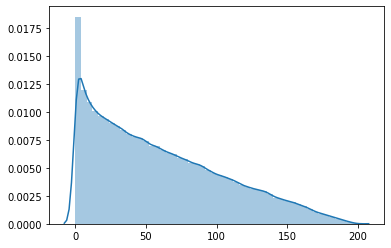

In [189]:
times = np.concatenate(all_times[1])
sns.distplot(times)

In [193]:
t_val = times[sorted_index]
t_val

array([ 0.       , 47.88739  , 93.00654  , ..., 11.193436 , 46.539505 ,
        3.1424942], dtype=float32)

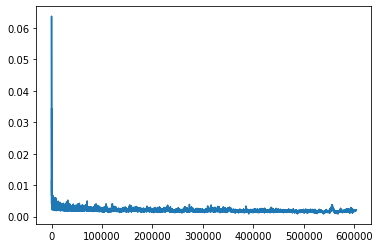

In [42]:
#11


times = np.concatenate(all_times[0])
k_val = np.concatenate(kernels[0])
sorted_index = np.argsort(times)
t_val = times[sorted_index]
k_val = k_val[sorted_index]


moving_average = 100

## Moving Average 
k_val = np.convolve(k_val, np.ones(moving_average), 'valid') / moving_average    
t_val = np.convolve(t_val, np.ones(moving_average), 'valid') / moving_average

plt.plot(t_val,k_val)

## Mimic

In [233]:

with open('data/mimic/test_manifold_format.pkl', 'rb') as f:
    loaded_hawkes_data = pickle.load(f)


test_seq_times, test_seq_types, test_seq_lengths, _ = process_loaded_sequences(loaded_hawkes_data, 75)

test_seq_lengths, reorder_indices_test = test_seq_lengths.sort(descending=True)
test_seq_times = test_seq_times[reorder_indices_test]
test_seq_types = test_seq_types[reorder_indices_test]

In [237]:

model = train_sahp.make_model(max_sequence_length=34,process_dim=75)
model_dict =torch.load('saved_models/sahp-mimic_hidden16-20211012-005042',map_location=torch.device('cpu'))
model.load_state_dict(model_dict)

RuntimeError: Error(s) in loading state_dict for SAHP:
	size mismatch for type_emb.weight: copying a param with shape torch.Size([76, 32]) from checkpoint, the shape in current model is torch.Size([76, 16]).
	size mismatch for position_emb.div_term: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for position_emb.Wt.weight: copying a param with shape torch.Size([16, 1]) from checkpoint, the shape in current model is torch.Size([8, 1]).
	size mismatch for attention.linear_layers.0.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for attention.linear_layers.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for attention.linear_layers.1.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for attention.linear_layers.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for attention.linear_layers.2.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for attention.linear_layers.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for attention.output_linear.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for attention.output_linear.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for feed_forward.w_1.weight: copying a param with shape torch.Size([128, 32]) from checkpoint, the shape in current model is torch.Size([64, 16]).
	size mismatch for feed_forward.w_1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for feed_forward.w_2.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([16, 64]).
	size mismatch for feed_forward.w_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for input_sublayer.norm.a_2: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for input_sublayer.norm.b_2: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for output_sublayer.norm.a_2: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for output_sublayer.norm.b_2: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for start_layer.0.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for start_layer.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for converge_layer.0.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for converge_layer.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decay_layer.0.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for decay_layer.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for intensity_layer.0.weight: copying a param with shape torch.Size([75, 32]) from checkpoint, the shape in current model is torch.Size([75, 16]).

In [226]:
### StackOverflow

## Retweet

In [2]:
## Load Data Set
dataset = 'retweet'
process_dim =3 

train_path = 'data/' + dataset + '/train_manifold_format.pkl'
dev_path = 'data/' + dataset + '/dev_manifold_format.pkl'
test_path = 'data/' + dataset + '/test_manifold_format.pkl'

with open(train_path, 'rb') as f:
    train_hawkes_data = pickle.load(f)
with open(dev_path, 'rb') as f:
    dev_hawkes_data = pickle.load(f)
with open(test_path, 'rb') as f:
    test_hawkes_data = pickle.load(f)

train_seq_times, train_seq_types, train_seq_lengths, train_tmax = \
process_loaded_sequences(train_hawkes_data, process_dim)
dev_seq_times, dev_seq_types, dev_seq_lengths, dev_tmax = \
process_loaded_sequences(dev_hawkes_data, process_dim)
test_seq_times, test_seq_types, test_seq_lengths, test_tmax = \
process_loaded_sequences(test_hawkes_data, process_dim)

tmax = max([train_tmax, dev_tmax, test_tmax])


In [300]:
train_seq_times/tmax

tensor([[0.0000e+00, 4.6296e-05, 4.7950e-05,  ..., 6.2721e-01, 7.4688e-01,
         8.6557e-01],
        [0.0000e+00, 2.6439e-03, 3.3003e-03,  ..., 1.0255e-01, 1.6000e-01,
         2.7989e-01],
        [0.0000e+00, 2.1495e-05, 2.8109e-05,  ..., 9.1505e-01, 9.1533e-01,
         9.2075e-01],
        ...,
        [0.0000e+00, 4.4643e-05, 5.7871e-05,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 2.1495e-05, 3.9683e-05,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 3.3069e-05, 5.1257e-05,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00]])

In [3]:
device = 'cpu'

train_sample_size = train_seq_times.size(0)
print("Train sample size: {}".format(train_sample_size))

dev_sample_size = dev_seq_times.size(0)
print("Dev sample size: {}".format(dev_sample_size))

test_sample_size = test_seq_times.size(0)
print("Test sample size: {}".format(test_sample_size))


# Define training data
train_seq_times = train_seq_times.to(device)
train_seq_types = train_seq_types.to(device)
train_seq_lengths = train_seq_lengths.to(device)
print("No. of event tokens in training subset:", train_seq_lengths.sum())

# Define development data
dev_seq_times = dev_seq_times.to(device)
dev_seq_types = dev_seq_types.to(device)
dev_seq_lengths = dev_seq_lengths.to(device)
print("No. of event tokens in development subset:", dev_seq_lengths.sum())

# Define test data
test_seq_times = test_seq_times.to(device)
test_seq_types = test_seq_types.to(device)
test_seq_lengths = test_seq_lengths.to(device)
print("No. of event tokens in test subset:", test_seq_lengths.sum())


## sequence length
train_seq_lengths, reorder_indices_train = train_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
train_seq_times = train_seq_times[reorder_indices_train]
train_seq_types = train_seq_types[reorder_indices_train]
#
dev_seq_lengths, reorder_indices_dev = dev_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
dev_seq_times = dev_seq_times[reorder_indices_dev]
dev_seq_types = dev_seq_types[reorder_indices_dev]

test_seq_lengths, reorder_indices_test = test_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
test_seq_times = test_seq_times[reorder_indices_test]
test_seq_types = test_seq_types[reorder_indices_test]

max_sequence_length = max(train_seq_lengths[0], dev_seq_lengths[0], test_seq_lengths[0])
print('max_sequence_length: {}'.format(max_sequence_length))

Train sample size: 20000
Dev sample size: 2000
Test sample size: 2000
No. of event tokens in training subset: tensor(2176116)
No. of event tokens in development subset: tensor(215521)
No. of event tokens in test subset: tensor(218465)
max_sequence_length: 264


In [4]:
model = train_sahp.make_model(max_sequence_length=max_sequence_length+1, process_dim=3)
model_dict =torch.load('saved_models/retweet/sahp-retweet_hidden16-20211014-020232',map_location=torch.device('cpu'))
model.load_state_dict(model_dict)

torch.manual_seed(42)
batch_size = 32
test_size = test_seq_times.size(0)
device = 'cpu'
test_loop_range = list(range(0, test_size, batch_size))


In [5]:
avg_rmse, types_predict_score, results = prediction_evaluation(
    device, model, test_seq_lengths, test_seq_times, test_seq_types, 1, 40)

100%|██████████████████████████████████████| 2000/2000 [00:28<00:00, 69.98it/s]


rmse 127645.66957010332
Type prediction score: 0.531


In [6]:
test_data = (test_seq_times, test_seq_types, test_seq_lengths)
incr_estimates, incr_reals, types_real, types_estimates = \
    evaluation.predict_test(model, *test_data, pad=model.process_dim, device=device,
                            hmax=tmax, use_jupyter=False, rnn=False)

100%|██████████████████████████████████████| 2000/2000 [00:30<00:00, 66.35it/s]


In [33]:
np.mean(np.abs(incr_reals-incr_estimates)**2)

16279273000.0

In [29]:
np.sqrt(np.mean((np.abs(incr_estimates[incr_reals!=0] -incr_reals[incr_reals!=0])/incr_reals[incr_reals!=0])**2))

14.138854

In [20]:
 incr_reals==0

array([False, False, False, ..., False, False, False])

### Training

In [50]:
process_dim = 2
device = 'cpu'
train_ratio = 0.8
lr = 5e-5
batch_size = 32


torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


with open('data/simulated/hawkes_synthetic_random_2d_20191130-180837.pkl', 'rb') as f:
    loaded_hawkes_data = pickle.load(f)
    
process_dim = loaded_hawkes_data['process_dim'] if 'process_dim' in loaded_hawkes_data.keys() else process_dim

seq_times, seq_types, seq_lengths, _ = process_loaded_sequences(loaded_hawkes_data, process_dim)

seq_times = seq_times.to(device)
seq_types = seq_types.to(device)
seq_lengths = seq_lengths.to(device)

total_sample_size = seq_times.size(0)
print("Total sample size: {}".format(total_sample_size))

train_size = int(train_ratio * total_sample_size)
dev_ratio = 0.1
dev_size = int(dev_ratio * total_sample_size)
print("Train sample size: {:}/{:}".format(train_size, total_sample_size))
print("Dev sample size: {:}/{:}".format(dev_size, total_sample_size))

# Define training data
train_seq_times = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("No. of event tokens in training subset:", train_seq_lengths.sum())

# Define development data
dev_seq_times = seq_times[train_size:train_size + dev_size]  # train_size+dev_size
dev_seq_types = seq_types[train_size:train_size + dev_size]
dev_seq_lengths = seq_lengths[train_size:train_size + dev_size]
print("No. of event tokens in development subset:", dev_seq_lengths.sum())

test_seq_times = seq_times[-dev_size:]
test_seq_types = seq_types[-dev_size:]
test_seq_lengths = seq_lengths[-dev_size:]

print("No. of event tokens in test subset:", test_seq_lengths.sum())

## sequence length
train_seq_lengths, reorder_indices_train = train_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
train_seq_times = train_seq_times[reorder_indices_train]
train_seq_types = train_seq_types[reorder_indices_train]
#
dev_seq_lengths, reorder_indices_dev = dev_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
dev_seq_times = dev_seq_times[reorder_indices_dev]
dev_seq_types = dev_seq_types[reorder_indices_dev]

test_seq_lengths, reorder_indices_test = test_seq_lengths.sort(descending=True)
# # Reorder by descending sequence length
test_seq_times = test_seq_times[reorder_indices_test]
test_seq_types = test_seq_types[reorder_indices_test]

max_sequence_length = max(train_seq_lengths[0], dev_seq_lengths[0], test_seq_lengths[0])
print('max_sequence_length: {}'.format(max_sequence_length))


d_model = 16
atten_heads = 1
dropout = 0.1

model = make_model(nLayers=1, d_model=d_model, atten_heads=atten_heads,
                   dropout=dropout, process_dim=process_dim, device=device, pe='add',
                   max_sequence_length=max_sequence_length + 1).to(device)

print("the number of trainable parameters: " + str(count_parameters(model)))


optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=3e-4)
model_opt = NoamOpt(d_model, 1, 100, initial_lr=lr, optimizer=optimizer)


## Size of the traing dataset
train_size = train_seq_times.size(0)
dev_size = dev_seq_times.size(0)
test_size = test_seq_times.size(0)
tr_loop_range = list(range(0, train_size, batch_size))
de_loop_range = list(range(0, dev_size, batch_size))
test_loop_range = list(range(0, test_size, batch_size))

last_dev_loss = 0.0
early_step = 0

random_seeds = list(range(0, 1000))
random.shuffle(random_seeds)

model.train()


Total sample size: 4000
Train sample size: 3200/4000
Dev sample size: 400/4000
No. of event tokens in training subset: tensor(498611)
No. of event tokens in development subset: tensor(63349)
No. of event tokens in test subset: tensor(61657)
max_sequence_length: 323
the number of trainable parameters: 4186


SAHP(
  (gelu): GELU()
  (type_emb): TypeEmbedding(3, 16, padding_idx=2)
  (position_emb): BiasedPositionalEmbedding(
    (Wt): Linear(in_features=1, out_features=8, bias=False)
  )
  (attention): MultiHeadedAttention(
    (linear_layers): ModuleList(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=16, bias=True)
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
    (output_linear): Linear(in_features=16, out_features=16, bias=True)
    (attention): Attention()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
    (w_1): Linear(in_features=16, out_features=64, bias=True)
    (w_2): Linear(in_features=64, out_features=16, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (activation): GELU()
  )
  (input_sublayer): SublayerConnection(
    (norm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (output_sublayer): SublayerConnection(
    (norm):

In [88]:
i_batch = 0
model_opt.optimizer.zero_grad()

batch_onehot, batch_seq_times, batch_dt, batch_seq_types, _, _, _, batch_seq_lengths = \
    get_batch(batch_size, i_batch, model, train_seq_lengths, train_seq_times, train_seq_types,
                   rnn=False)

batch_seq_types = batch_seq_types[:, 1:]

masked_seq_types = MaskBatch(batch_seq_types, pad=model.process_dim,
                             device=device)  # exclude the first added even
model.forward(batch_dt, masked_seq_types.src, masked_seq_types.src_mask)
# nll = model.compute_loss(batch_seq_times, batch_onehot)

In [181]:
### Loss Function
def compute_loss(model,seq_times,seq_onehot_types,n_mc_samples = 20):
    dt_seq = seq_times[:, 1:] - seq_times[:, :-1]
    cell_t = model.state_decay(model.converge_point, model.start_point, model.omega, dt_seq[:, :, None])

    n_batch = seq_times.size(0)
    n_times = seq_times.size(1) - 1
    device = dt_seq.device
    # Get the intensity process
    intens_at_evs = model.intensity_layer(cell_t)
    
    
    log_intensities = intens_at_evs.log()  # log intensities
    log_intensities =  log_intensities*seq_onehot_types[:, 1:, :].sum(dim=-1).unsqueeze(-1)
    
    
    
    seq_mask = seq_onehot_types[:, 1:]
    log_sum = (log_intensities * seq_mask).sum(dim=(2, 1)) 
    
    
    taus = torch.rand(n_batch, n_times, 1, n_mc_samples).to(device) 
    taus = dt_seq[:, :, None, None] * taus 
    
    
    cell_tau = model.state_decay(
    model.converge_point[:, :, :, None],
    model.start_point[:, :, :, None],
    model.omega[:, :, :, None],
    taus)
    
    cell_tau = cell_tau.transpose(2, 3)
    intens_at_samples = model.intensity_layer(cell_tau).transpose(2, 3)
    intens_at_samples = intens_at_samples*seq_onehot_types[:, 1:, :].sum(dim=-1).unsqueeze(-1).unsqueeze(-1)
    
    
    total_intens_samples = intens_at_samples.sum(dim=2)  # shape batch * N * MC
    partial_integrals = dt_seq * total_intens_samples.mean(dim=2)

    integral_ = partial_integrals.sum(dim=1)

    res = torch.sum(- log_sum + integral_)
    
    
    return res

## Training Other 2-D Samples

In [184]:
process_dim = 2
device = 'cpu'
train_ratio = 0.8
lr = 5e-5
batch_size = 32


torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


with open('data/simulated/hawkes_2d.pkl', 'rb') as f:
    loaded_hawkes_data = pickle.load(f)

In [185]:
process_dim = loaded_hawkes_data['process_dim'] if 'process_dim' in loaded_hawkes_data.keys() else process_dim


In [186]:
process_dim

1